# Data Analysis

## Relevant Imports

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as stats
import seaborn as sns

from sklearn.model_selection import train_test_split

## Extra Cleaning and Sanity Checks

Though all relevant data was extracted and pre-processed in the previous notebooks, it is important to ensure the data is clean before proceeding. Running these cells after each change in the previous notebooks might prove useful.

In [2]:
annual_data = pd.read_csv("datasets/processed/cleaned_urban_internet_data_no_outliers.csv")

In [3]:
# Step 1: Check for missing values in relevant columns
print(annual_data['avg_d_kbps'].isna().sum())
print(annual_data['normalized_light_intensity'].isna().sum())

# Step 2: Convert columns to numeric, coercing errors to NaN
annual_data['avg_d_kbps'] = pd.to_numeric(annual_data['avg_d_kbps'], errors='coerce')
annual_data['normalized_light_intensity'] = pd.to_numeric(annual_data['normalized_light_intensity'], errors='coerce')

# Step 3: Drop rows with NaN values in critical columns
data = annual_data.dropna(subset=['avg_d_kbps', 'normalized_light_intensity'])

# Step 4: Verify the data types of the columns
print("\nData types after conversion:")
print(data.dtypes)

0
0

Data types after conversion:
country                        object
normalized_light_intensity    float64
avg_d_kbps                    float64
avg_u_kbps                    float64
avg_lat_ms                    float64
tests                         float64
year                            int64
geometry                       object
dtype: object


### Cleaned data preview

In [4]:
data.columns

Index(['country', 'normalized_light_intensity', 'avg_d_kbps', 'avg_u_kbps',
       'avg_lat_ms', 'tests', 'year', 'geometry'],
      dtype='object')

In [5]:
data.head()

,country,normalized_light_intensity,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,year,geometry
0,Philippines,0.358053,49756.00,53303.333333,11.666667,2.333333,2020,"POLYGON ((120.097045898438 16.1302620120348, 1..."
1,Taiwan,0.300128,87722.50,39520.000000,10.250000,185.500000,2020,"POLYGON ((120.173950195312 22.9937949722422, 1..."
2,Taiwan,0.322265,75952.50,34794.500000,11.250000,176.750000,2020,"POLYGON ((120.173950195312 22.9988515941429, 1..."
3,Taiwan,0.303183,76479.75,35316.250000,8.250000,261.500000,2020,"POLYGON ((120.173950195312 23.0039080266307, 1..."
4,Taiwan,0.306424,77667.00,36724.250000,16.250000,167.750000,2020,"POLYGON ((120.179443359375 22.9937949722422, 1..."


#### Histograms

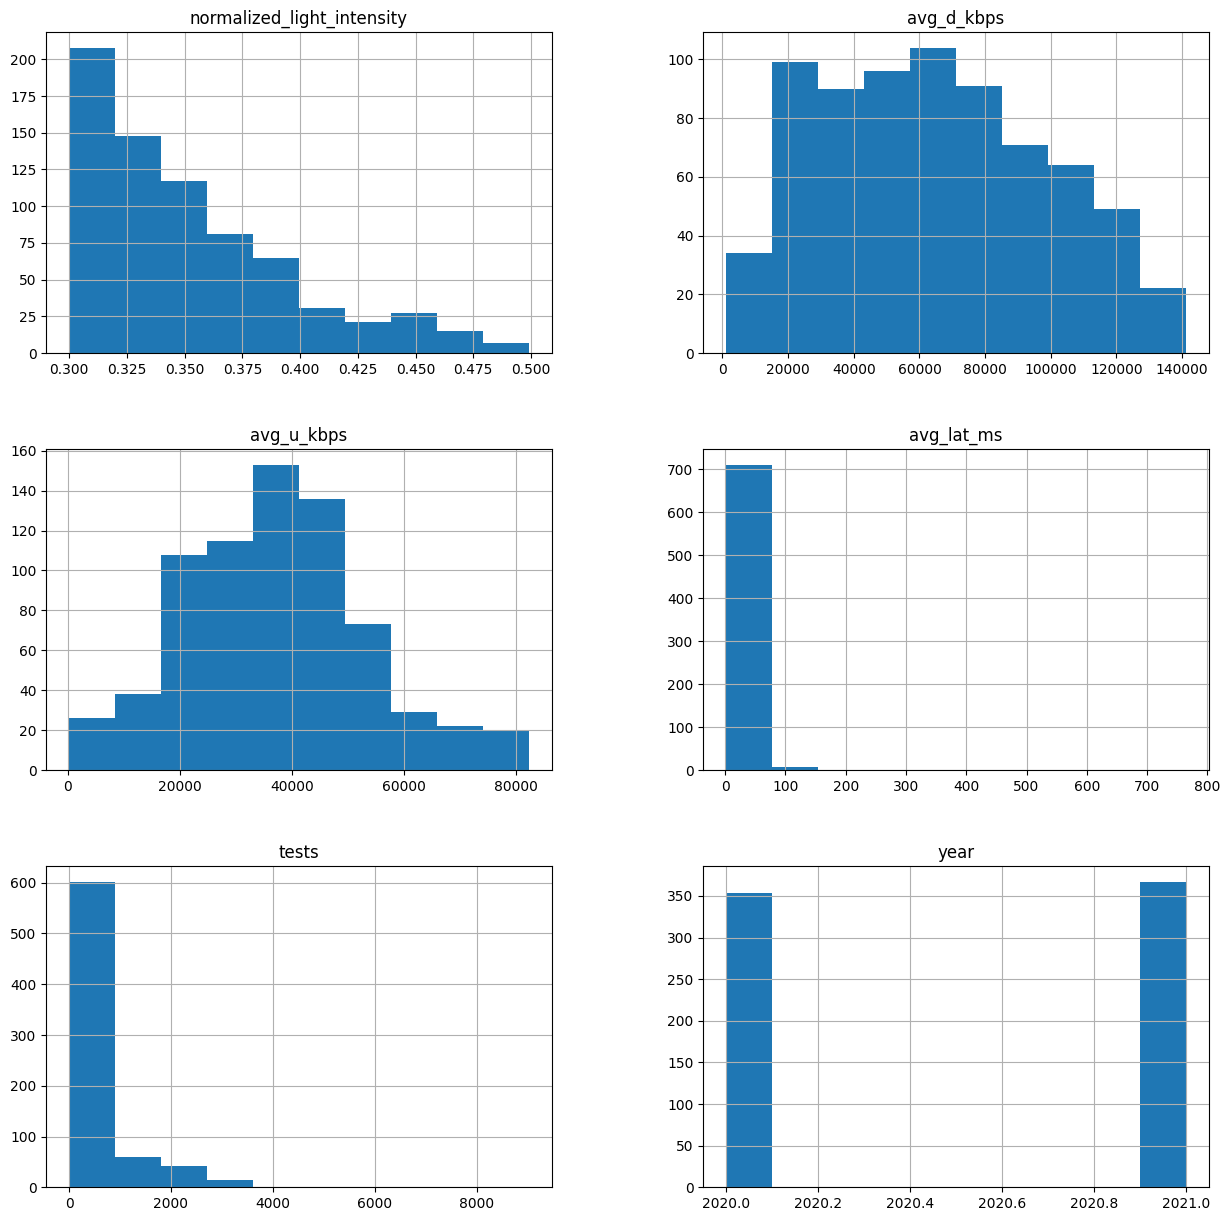

In [6]:
# Select only numeric columns for histograms
numeric_columns = data.select_dtypes(include='number').columns

# Plot histograms for the numeric columns
data[numeric_columns].hist(figsize=(15, 15))

# Display the histograms
plt.show()

#### Pairplots

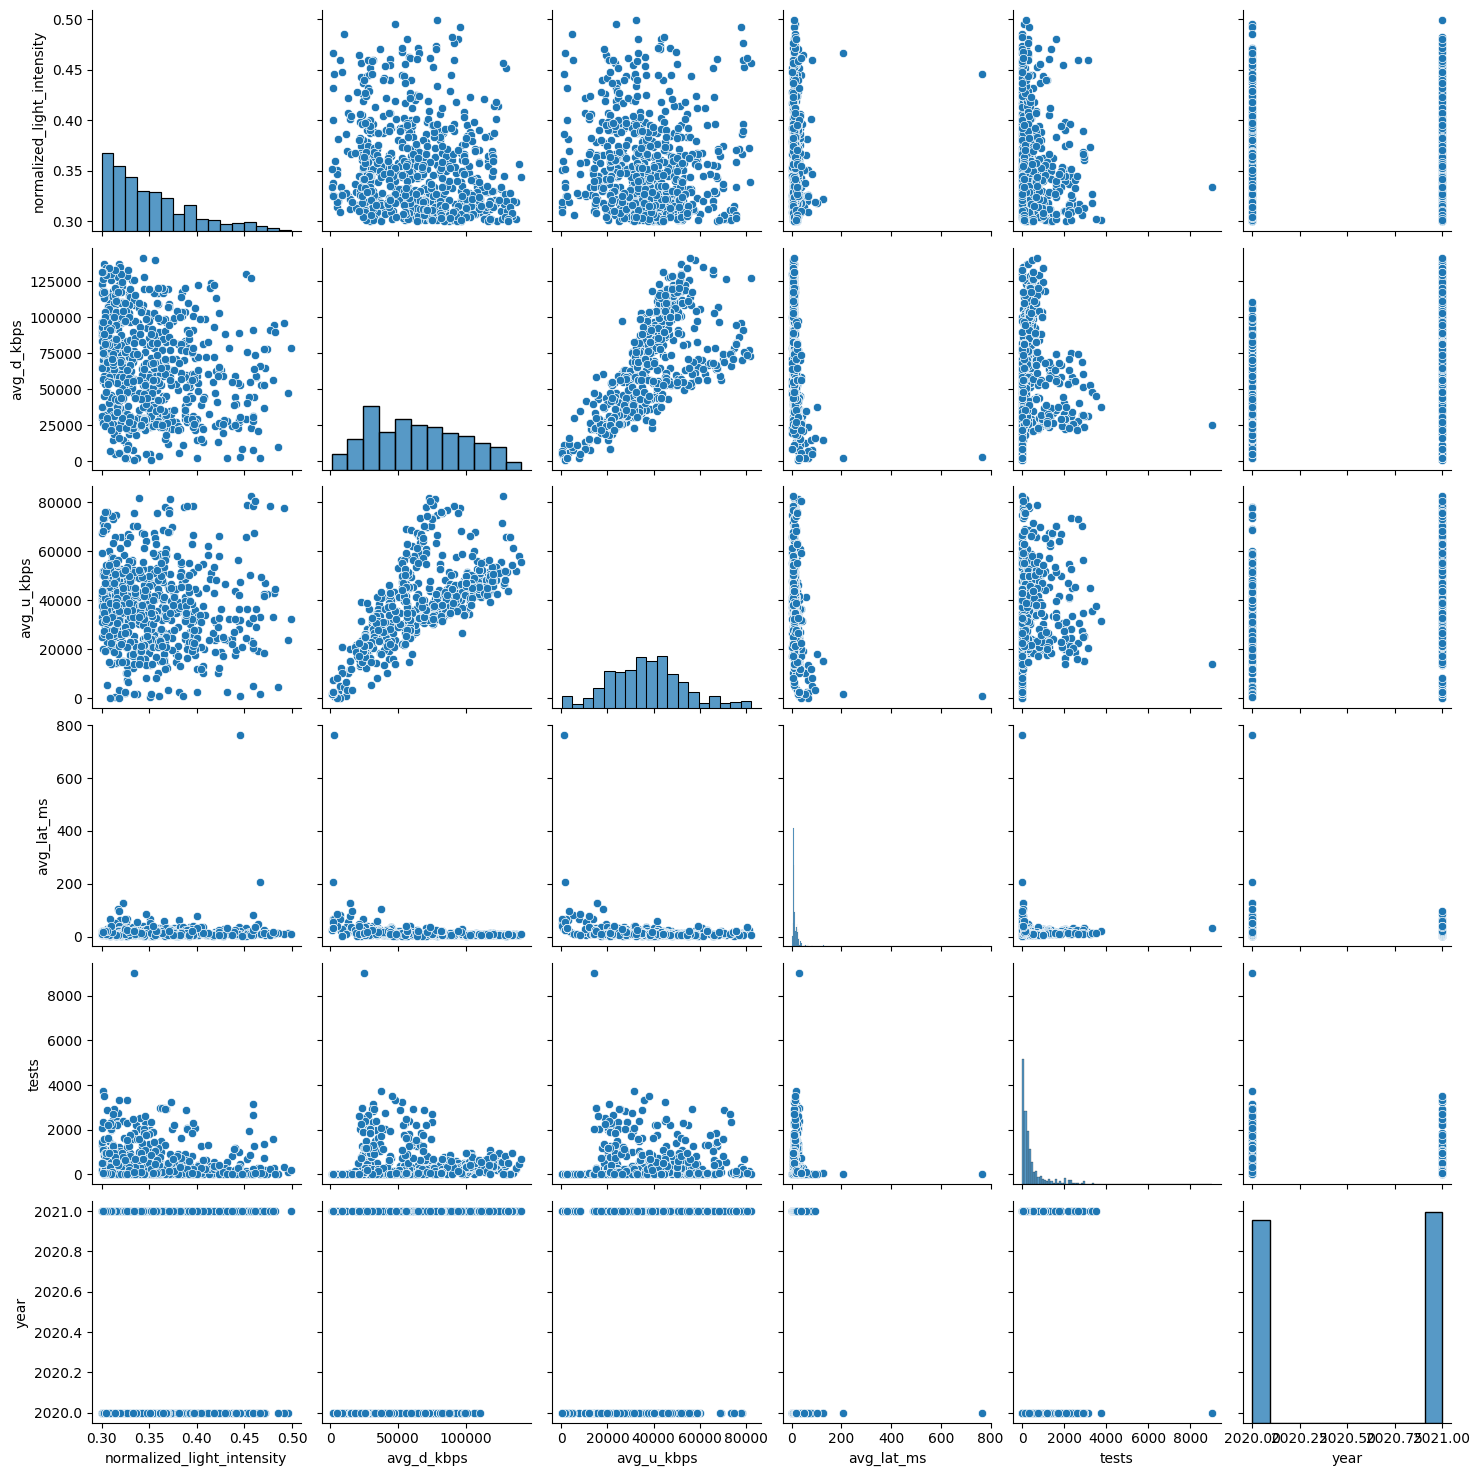

In [7]:
# Pairplot for EDA
sns.pairplot(data)
plt.show()

In [8]:
data = pd.read_csv("datasets/processed/average_urban_internet_data.csv")

##  Heatmaps

### Radiance levels of urban areas in different countries

C:\Users\bodbo\AppData\Local\Temp\ipykernel_10216\2984939818.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['country', 'light_intensity_range'])['avg_d_kbps'].mean().reset_index()
C:\Users\bodbo\AppData\Local\Temp\ipykernel_10216\2984939818.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = grouped_data.pivot_table(


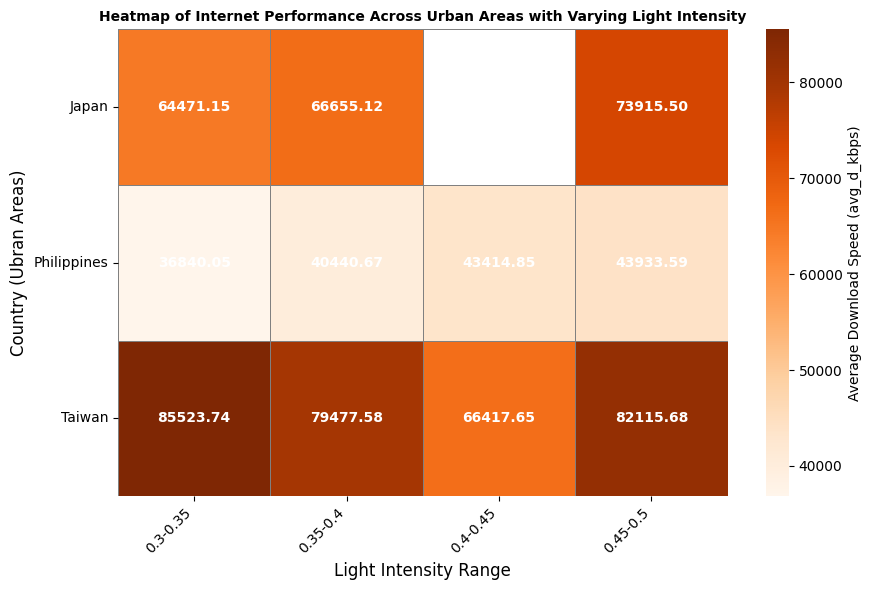

In [9]:
# Define the bin edges and corresponding labels for 'normalized_light_intensity'
bins = [0.3, 0.35, 0.4, 0.45, 0.5]
labels = ['0.3-0.35', '0.35-0.4', '0.4-0.45', '0.45-0.5']

# Create a new column 'light_intensity_range' to categorize light intensity values into bins
data['light_intensity_range'] = pd.cut(
    data['normalized_light_intensity'], 
    bins=bins,
    labels=labels, 
    include_lowest=True
)

# Group the data by 'country' and 'light_intensity_range', then calculate the average download speed
grouped_data = data.groupby(['country', 'light_intensity_range'])['avg_d_kbps'].mean().reset_index()

# Pivot the grouped data to create a matrix for the heatmap, with countries as rows and light intensity ranges as columns
heatmap_data = grouped_data.pivot_table(
    index='country', 
    columns='light_intensity_range', 
    values='avg_d_kbps'
)

# Set up the plot with a larger figure size for readability
plt.figure(figsize=(9, 6))

# Create the heatmap with customized annotations and color settings
sns.heatmap(
    heatmap_data, 
    annot=True,  # Show values in each cell
    fmt='.2f',  # Format numbers to two decimal places
    cmap='Oranges',  # Color map for the heatmap
    cbar_kws={'label': 'Average Download Speed (avg_d_kbps)'},  # Label for the color bar
    annot_kws={'size': 10, 'weight': 'bold', 'color': 'white'},  # Styling for annotations
    linewidths=0.5,  # Line width between cells
    linecolor='gray'  # Color for cell borders
)

# Add title and axis labels with adjusted font sizes
plt.title("Heatmap of Internet Performance Across Urban Areas with Varying Light Intensity", fontsize=10, weight='bold')
plt.xlabel("Light Intensity Range", fontsize=12)
plt.ylabel("Country (Ubran Areas)", fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=10)
# Rotate y-axis labels to be horizontal
plt.yticks(rotation=0, fontsize=10)

# Adjust layout for better spacing and clarity
plt.tight_layout()

# Display the plot
plt.show()

### Radiance Intensity vs Internet Speeds

C:\Users\bodbo\AppData\Local\Temp\ipykernel_10216\1165337403.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = data.groupby(['speed_bin', 'radiance_bin']).size().unstack(fill_value=0)


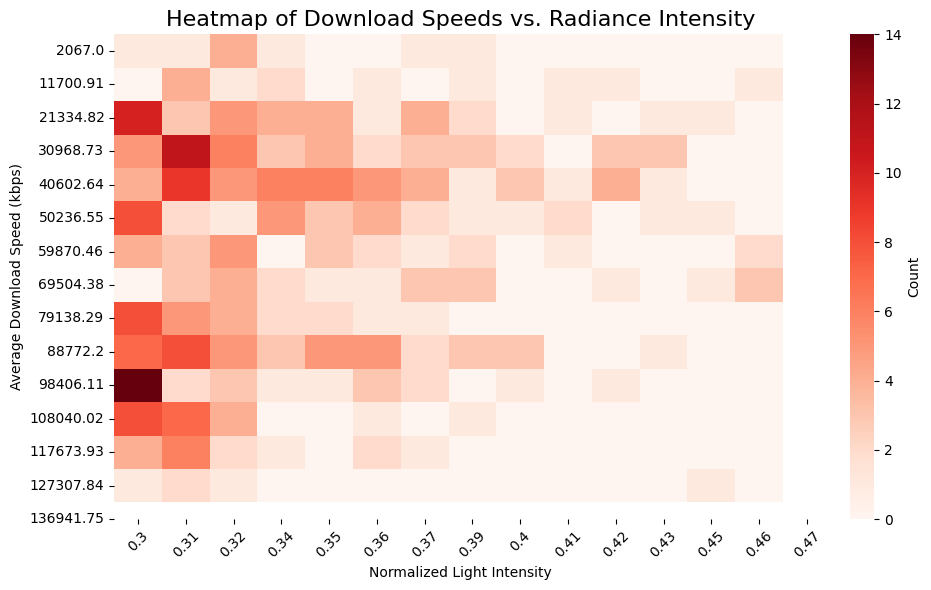

In [10]:
# Define bin edges for continuous variables
speed_bins = np.linspace(data['avg_d_kbps'].min(), data['avg_d_kbps'].max(), 15)  # Adjust number of bins as needed
radiance_bins = np.linspace(data['normalized_light_intensity'].min(), data['normalized_light_intensity'].max(), 15)

# Bin the data
data['speed_bin'] = pd.cut(data['avg_d_kbps'], bins=speed_bins, labels=speed_bins[1:])
data['radiance_bin'] = pd.cut(data['normalized_light_intensity'], bins=radiance_bins, labels=radiance_bins[:-1])

# Create a pivot table to calculate average or count
heatmap_data = data.groupby(['speed_bin', 'radiance_bin']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    cmap='Reds',
    xticklabels=radiance_bins.round(2),  # Optional: adjust rounding for clarity
    yticklabels=speed_bins.round(2),
    cbar_kws={'label': 'Count'}  # Adjust label to match aggregation (e.g., 'Average', 'Count')
)
sns.light_palette("seagreen", as_cmap=True)
plt.title("Heatmap of Download Speeds vs. Radiance Intensity", fontsize=16)
plt.xlabel("Normalized Light Intensity")
plt.ylabel("Average Download Speed (kbps)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scatter Plot
**Objective**: Correlate radiance values with internet performance metrics.

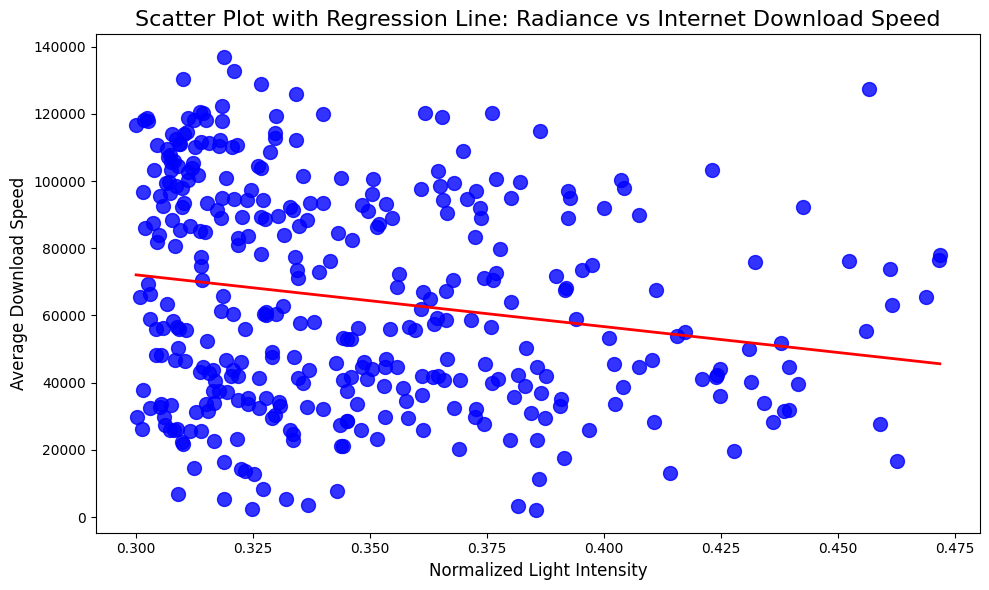

In [11]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=data, 
    x='normalized_light_intensity',  # Radiance values
    y='avg_d_kbps',  # Internet download speed
    scatter_kws={'color': 'blue', 's': 100},  # Customize scatter points
    line_kws={'color': 'red', 'lw': 2},  # Customize regression line
    ci=None  # Disable confidence interval for the regression line
)


plt.title("Scatter Plot with Regression Line: Radiance vs Internet Download Speed", fontsize=16)
plt.xlabel("Normalized Light Intensity", fontsize=12)
plt.ylabel("Average Download Speed", fontsize=12)


plt.tight_layout()
plt.show()

### Correlation between the two features.

In [12]:
correlation = data[['normalized_light_intensity', 'avg_d_kbps']].corr()
correlation

,normalized_light_intensity,avg_d_kbps
normalized_light_intensity,1.00000,-0.19052
avg_d_kbps,-0.19052,1.00000


Since r = -0.19052, therefore internet speed and light intensity are weakly negatively correlated. (r > -0.3)

## Bar Chart
**Objective**: Compare internet performance across urban areas with varying light intensity.


C:\Users\bodbo\AppData\Local\Temp\ipykernel_10216\2453144383.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['country', 'light_intensity_range'])['avg_d_kbps'].mean().reset_index()


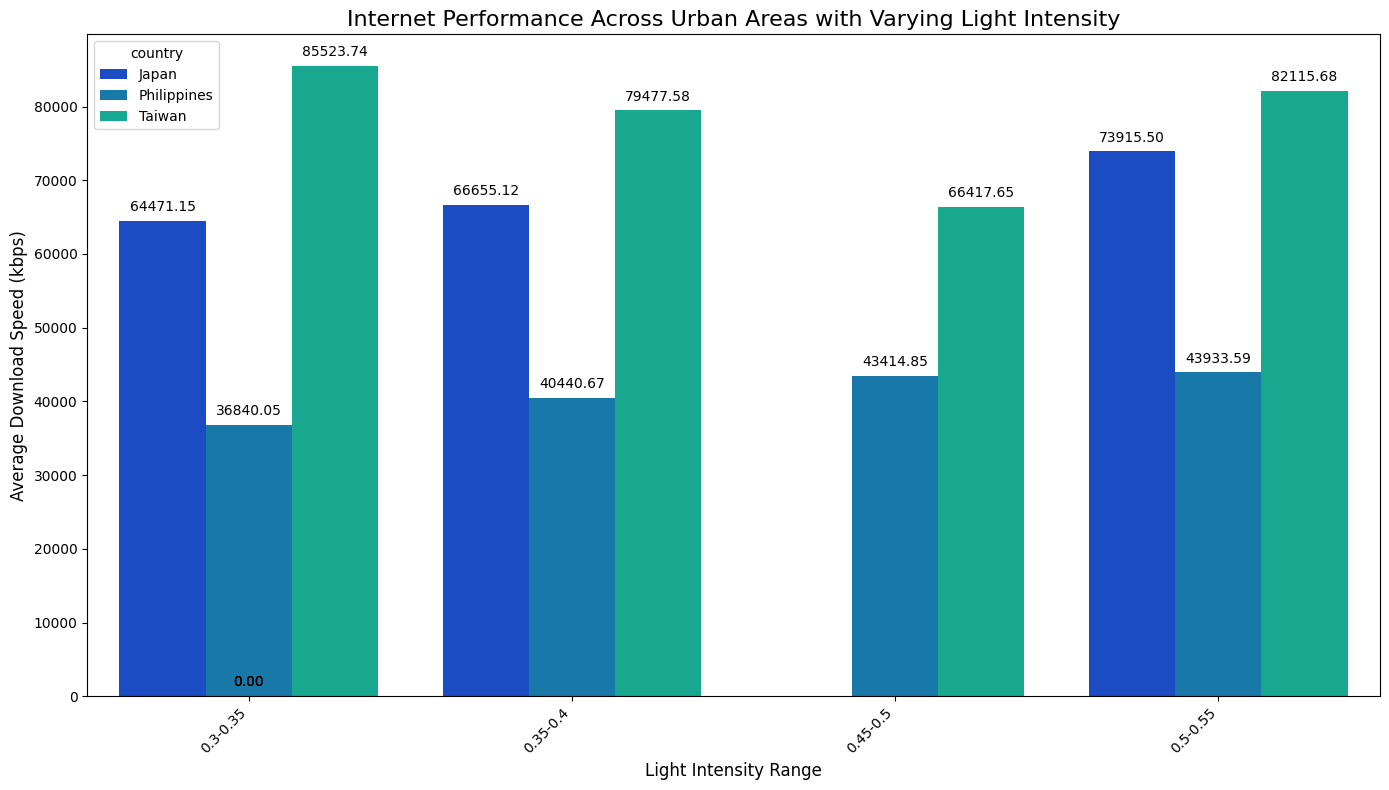

In [13]:
# Define the light intensity range bins and labels
bins = [0.3, 0.35, 0.4, 0.45, 0.5]
labels = ['0.3-0.35', '0.35-0.4', '0.45-0.5', '0.5-0.55']

# Bin the 'normalized_light_intensity' values and create a new column for the intensity range
data['light_intensity_range'] = pd.cut(
    data['normalized_light_intensity'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Group data by 'country' and 'light_intensity_range', then calculate the mean download speed for each group
grouped_data = data.groupby(['country', 'light_intensity_range'])['avg_d_kbps'].mean().reset_index()

# Get the frequency of each light intensity range to order the bars dynamically
freq = grouped_data['light_intensity_range'].value_counts()
range_order = freq.index

# Define a color palette for the plot
palette = "winter"

# Set up the plot size for better readability
plt.figure(figsize=(14, 8))

# Plot the bar chart, ordering the bars based on the frequency of the light intensity ranges
ax = sns.barplot(
    data=grouped_data, 
    x='light_intensity_range', 
    y='avg_d_kbps', 
    hue='country', 
    palette=palette, 
    order=range_order
)

# Annotate each bar with its corresponding average download speed
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',  # Show value with two decimal places
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position above the bar
        ha='center', va='center', fontsize=10, color='black', 
        xytext=(0, 10), textcoords='offset points'
    )

# Format x-axis labels and adjust their position
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add title and axis labels
plt.title("Internet Performance Across Urban Areas with Varying Light Intensity", fontsize=16)
plt.xlabel("Light Intensity Range", fontsize=12)
plt.ylabel("Average Download Speed (kbps)", fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Line Chart
**Objective:** Show annual trends in radiance and internet speeds for selected countries.

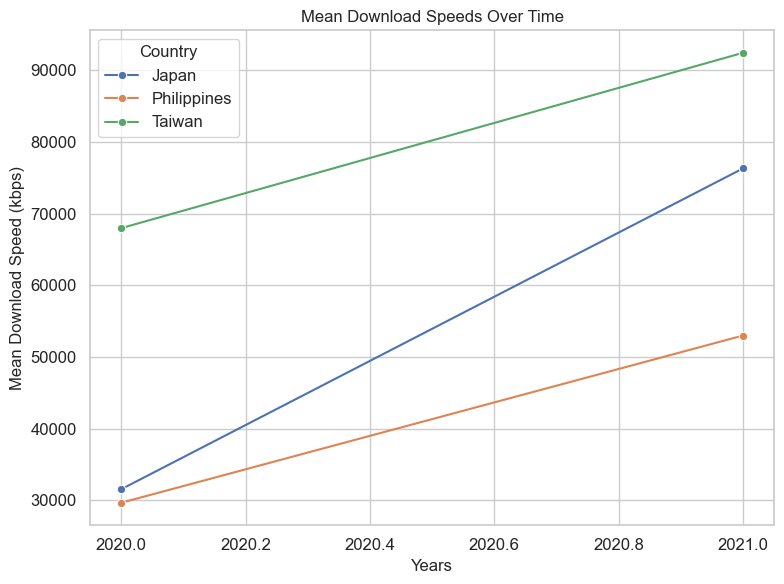

In [14]:
# File paths
input_cleaned_data = "datasets/processed/cleaned_urban_internet_data_no_outliers.csv"

# Load the cleaned data
cleaned_data = pd.read_csv(input_cleaned_data)

# Select cities (or countries) to analyze
selected_cities = ['Japan', 'Philippines', 'Taiwan']  # Replace with your cities or countries of interest

# Filter the data for the selected cities
filtered_data = cleaned_data[cleaned_data['country'].isin(selected_cities)]

# Group by year and country, then calculate annual averages
annual_trends = filtered_data.groupby(['country', 'year'], as_index=False).agg({
    'normalized_light_intensity': 'mean',
    'avg_d_kbps': 'mean'
})

# Prepare the plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Plot radiance vs download speeds
sns.lineplot(
    data=annual_trends,
    x='year',
    y='avg_d_kbps',
    hue='country',
    marker='o'
).set(
    title="Mean Download Speeds Over Time",
    xlabel="Years",
    ylabel="Mean Download Speed (kbps)"
)

# Customize the legend and layout
plt.legend(title='Country', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

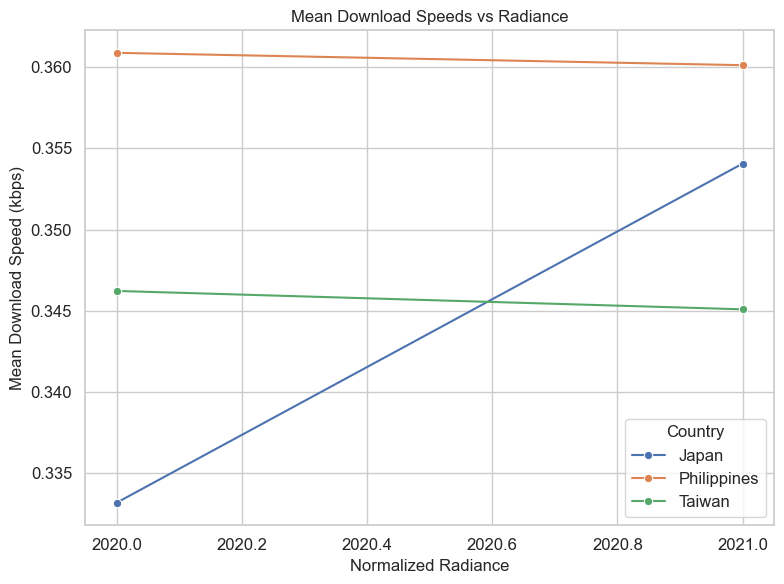

In [15]:
# Prepare the plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Plot radiance vs download speeds
sns.lineplot(
    data=annual_trends,
    x='year',
    y='normalized_light_intensity',
    hue='country',
    marker='o'
).set(
    title="Mean Download Speeds vs Radiance",
    xlabel="Normalized Radiance",
    ylabel="Mean Download Speed (kbps)"
)

# Customize the legend and layout
plt.legend(title='Country', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

## Geospatial Overlay
**Objective**: Map urban regions with internet speeds and radiance data layered.


C:\Users\bodbo\AppData\Local\Temp\ipykernel_10216\1537850005.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


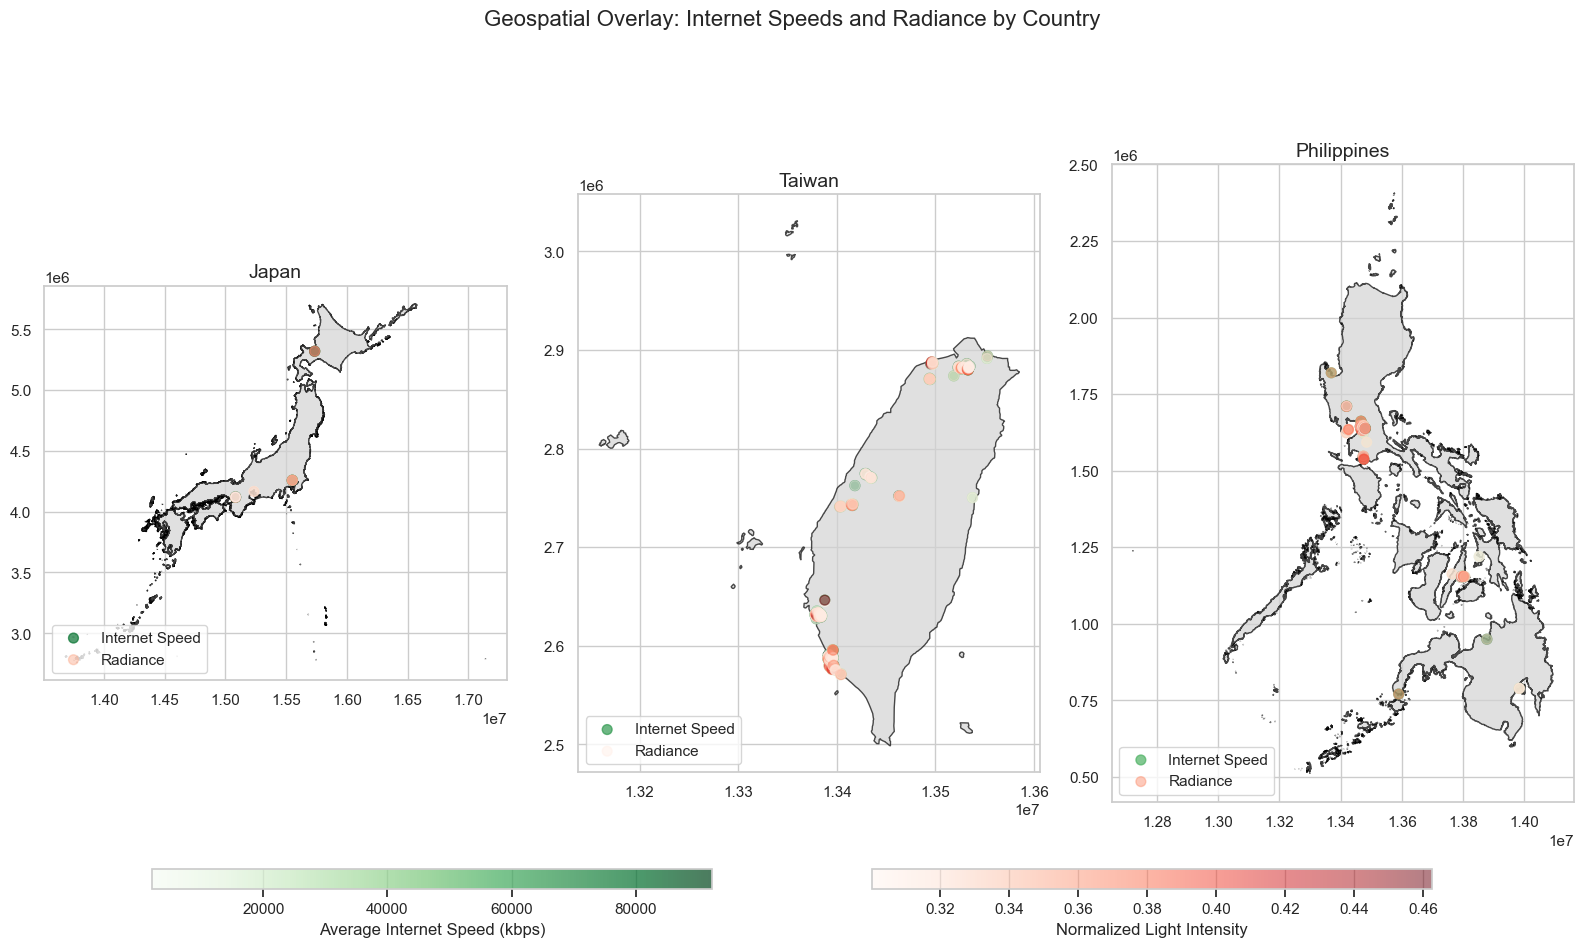

In [16]:
data = pd.read_csv("datasets/processed/average_urban_internet_data.csv")
# Folder containing GeoJSON boundary files
boundaries_folder = "boundaries"

# Mapping of country names to their ISO country codes
country_name_to_code = {
    "Japan": "JPN",
    "Taiwan": "TWN",
    "Philippines": "PHL"
}

# Add country codes to your cleaned dataset
data['country_code'] = data['country'].map(country_name_to_code)

# Convert cleaned dataset to a GeoDataFrame
data_gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.GeoSeries.from_wkt(data['geometry']),
    crs="EPSG:4326"
)

# Reproject to Web Mercator (EPSG:3857) for visualization
data_gdf = data_gdf.to_crs("EPSG:3857")

# Ensure all geometries are Points by converting to centroids if necessary
data_gdf['geometry'] = data_gdf['geometry'].apply(
    lambda geom: geom.centroid if geom.geom_type != 'Point' else geom
)

# Create subplots for each country
fig, axes = plt.subplots(1, 3, figsize=(16, 10))  # Adjust based on the number of countries
axes = axes.flatten()

for i, (country_name, country_code) in enumerate(country_name_to_code.items()):
    # Load the boundary GeoJSON for the current country
    boundary_file = os.path.join(boundaries_folder, f"geoBoundaries-{country_code}-ADM0.geojson")
    boundaries = gpd.read_file(boundary_file).to_crs("EPSG:3857")

    # Filter the cleaned dataset for the current country
    country_data = data_gdf[data_gdf['country_code'] == country_code]

    # Get the current subplot axis
    ax = axes[i]

    # Plot the country boundary
    boundaries.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)

    # Plot internet speed data
    sc_internet_speed = ax.scatter(
        country_data.geometry.x, country_data.geometry.y,
        c=country_data['avg_d_kbps'], cmap='Greens', s=50, alpha=0.7, label="Internet Speed"
    )

    # Plot radiance data
    sc_radiance = ax.scatter(
        country_data.geometry.x, country_data.geometry.y,
        c=country_data['normalized_light_intensity'], cmap='Reds', s=50, alpha=0.5, label="Radiance"
    )

    # Add title and legend
    ax.set_title(country_name, fontsize=14)
    ax.legend(loc="lower left")

# Adjust subplot spacing
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Add shared colorbars
cbar_ax_speed = fig.add_axes([0.1, 0.1, 0.35, 0.02])
fig.colorbar(sc_internet_speed, cax=cbar_ax_speed, orientation='horizontal', label='Average Internet Speed (kbps)')

cbar_ax_radiance = fig.add_axes([0.55, 0.1, 0.35, 0.02])  # Adjust position for the radiance colorbar
fig.colorbar(sc_radiance, cax=cbar_ax_radiance, orientation='horizontal', label='Normalized Light Intensity')

# Add main title
fig.suptitle("Geospatial Overlay: Internet Speeds and Radiance by Country", fontsize=16)

# Save and display the plot
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

## Hypothesis Testing

In [17]:
# Hypothesis:
# Null Hypothesis (H0): There is no significant correlation between internet performance and nighttime light intensity in urban regions.
# Alternative Hypothesis (H1): Internet performance is significantly correlated with nighttime light intensity in urban regions.

# Perform Pearson correlation test
correlation, p_value = stats.pearsonr(data['normalized_light_intensity'], data['avg_d_kbps'])

# Print the correlation coefficient and p-value
print(f"Pearson correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Set significance level (alpha)
alpha = 0.05

# Decision rule based on the p-value
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between internet performance and nighttime light intensity.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between internet performance and nighttime light intensity.")


Pearson correlation coefficient: -0.1905
P-value: 0.0003
Reject the null hypothesis: There is a significant correlation between internet performance and nighttime light intensity.


## Prediction Model

In [18]:
# Extracting X (Nighttime Light Intensity) and Y (Download Speed)
X = cleaned_data['normalized_light_intensity'].values
Y = cleaned_data['avg_d_kbps'].values

# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

###  1. Simple linear regression
<img src="https://miro.medium.com/max/584/1*BDnev89iHmFqbB-HY1MuRQ.png">

In [19]:
# Simple Linear Regression Function
def LR(X, Y):
    # Mean X and Y
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    # Number of data points
    n = len(X)
    # Using the formula to calculate 'a' and 'b'
    numerator = 0
    denominator = 0
    for i in range(n):
        numerator += (X[i] - mean_X) * (Y[i] - mean_Y)
        denominator += (X[i] - mean_X) ** 2
    a = numerator / denominator
    b = mean_Y - (a * mean_X)
    return a, b

# Train the linear regression model
a, b = LR(X_train, Y_train)

# Predicting values for the training set
Y_pred_train = a * X_train + b


#### Visualization of Simple Linear Regression
This section handles the plotting of the data and the regression line for simple linear regression.

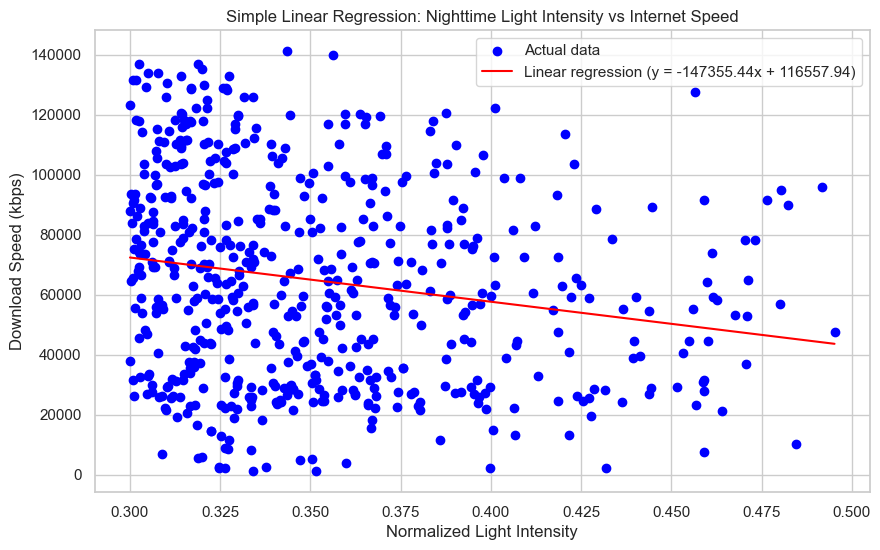

In [20]:
# Plotting Simple Linear Regression
plt.figure(figsize=(10, 6))
plt.title("Simple Linear Regression: Nighttime Light Intensity vs Internet Speed")
plt.scatter(X_train, Y_train, color='blue', label='Actual data')

# Sorting X_train for smooth regression line plotting
sorted_X = np.sort(X_train, axis=0)
Y_pred_sorted = a * sorted_X + b  # Predictions for sorted X values

# Plotting the linear regression line
plt.plot(sorted_X, Y_pred_sorted, color='red', label=f'Linear regression (y = {a:.2f}x + {b:.2f})')
plt.xlabel('Normalized Light Intensity')
plt.ylabel('Download Speed (kbps)')
plt.legend()
plt.show()


### Polynomial Regression Model 
This section defines the polynomial regression function, calculates the polynomial features, and computes the weights for the model.

In [21]:
# Polynomial Regression Function
def polynomial(X, degree):
    X_poly = []
    for n in range(1, degree + 1):
        X_poly.append(X ** n)
    X_poly.append(np.ones(len(X)))  # Adding the bias term (intercept)
    X_poly = np.array(X_poly).T
    return X_poly

# Calculating the weights for Polynomial Regression
def calculate_w(X, Y):
    XT = X.T
    XT_X = XT @ X
    XT_X_inv = np.linalg.pinv(XT_X)
    W = XT_X_inv @ XT @ Y
    return W

# Degree of Polynomial Regression
degree = 11
X_poly_train = polynomial(X_train, degree)
W = calculate_w(X_poly_train, Y_train)


#### Predictions and Visualization for Polynomial Regression
This section generates predictions for the test data using the polynomial regression model and visualizes the result.

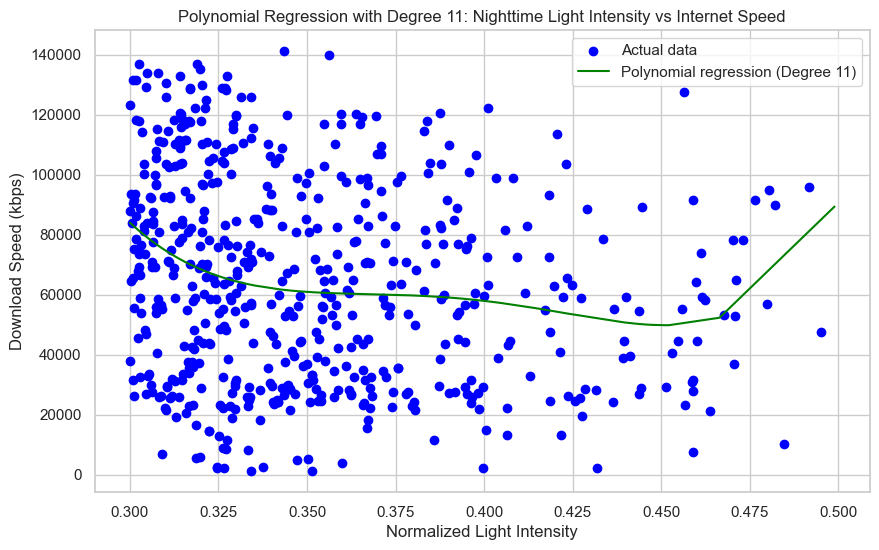

In [22]:
# Predicting values for the testing set using Polynomial Regression
X_poly_test = polynomial(X_test, degree)
Y_pred_test = np.matmul(X_poly_test, W)

# Plotting Polynomial Regression
plt.figure(figsize=(10, 6))
plt.title(f"Polynomial Regression with Degree {degree}: Nighttime Light Intensity vs Internet Speed")
plt.scatter(X_train, Y_train, color='blue', label='Actual data')

# Sorting X_test for smooth regression line plotting
sorted_X_test = np.sort(X_test, axis=0)
X_poly_sorted = polynomial(sorted_X_test, degree)
Y_pred_sorted_poly = np.matmul(X_poly_sorted, W)  # Predictions for sorted X values

# Plotting the polynomial regression line
plt.plot(sorted_X_test, Y_pred_sorted_poly, color='green', label=f'Polynomial regression (Degree {degree})')
plt.xlabel('Normalized Light Intensity')
plt.ylabel('Download Speed (kbps)')
plt.legend()
plt.show()


###  Model Evaluation
In this section, we calculate and compare the R² values for both the simple linear regression model and the polynomial regression model.

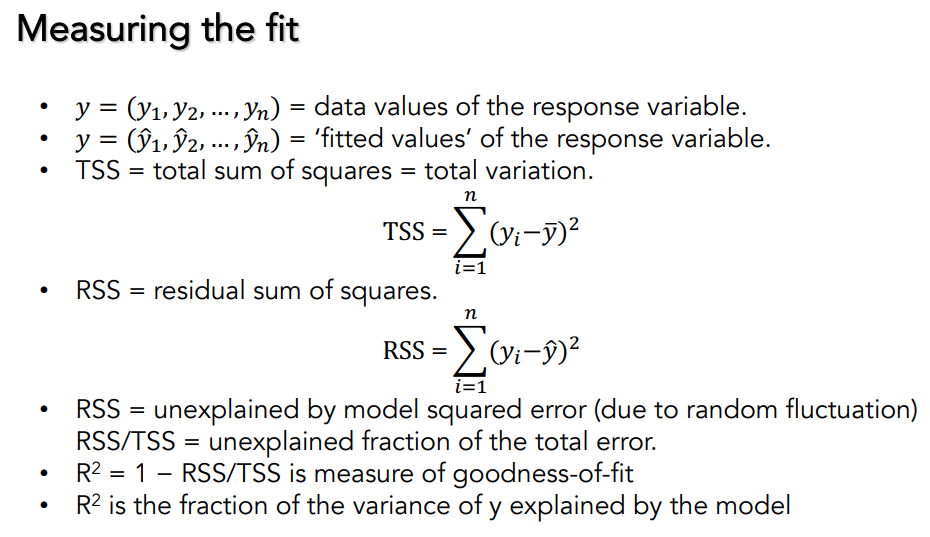

In [25]:
# Performance Evaluation
TSS = sum([(y - np.mean(Y_train)) ** 2 for y in Y_train])
RSS_linear = sum([(y - y_pred) ** 2 for y, y_pred in zip(Y_train, Y_pred_train)])
RSS_poly = sum([(y - y_pred) ** 2 for y, y_pred in zip(Y_test, Y_pred_test)])

R2_linear = 1 - RSS_linear / TSS
R2_poly = 1 - RSS_poly / TSS
print(TSS)

# Mean Squared Error for Linear Regression (Training Set)
MSE_linear = np.mean((Y_train - Y_pred_train) ** 2)
print(f"Mean Squared Error (Linear Regression) on Training Set: {MSE_linear:.4f}")
MSE_poly = np.mean((Y_test - Y_pred_test) ** 2)
print(f"Mean Squared Error (Polynomial Regression) on Test Set: {MSE_poly:.4f}")

print(f"Linear Regression R²: {R2_linear:.4f}")
print(f"Polynomial Regression R²: {R2_poly:.4f}")

664234733669.0028
Mean Squared Error (Linear Regression) on Training Set: 1111309937.8138
Mean Squared Error (Polynomial Regression) on Test Set: 973429165.9566
Linear Regression R²: 0.0363
Polynomial Regression R²: 0.7890


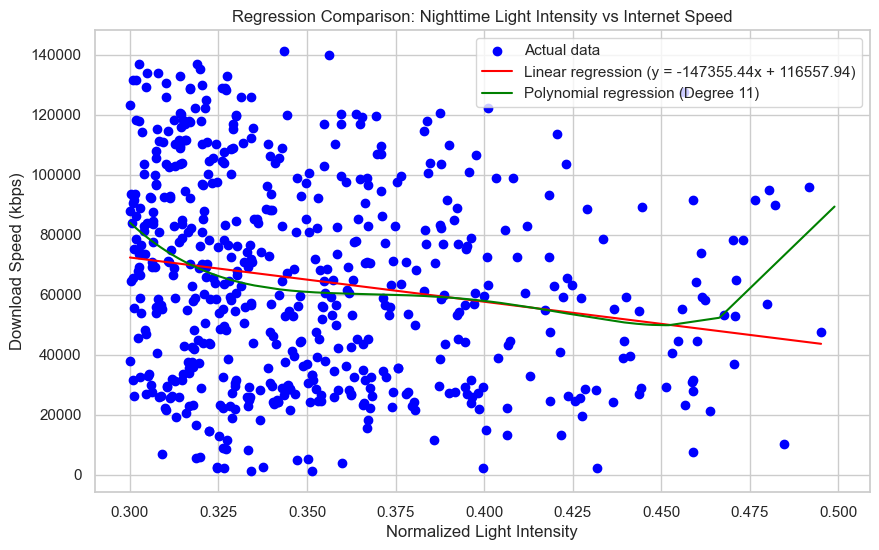

In [26]:
# Plotting both Simple Linear and Polynomial Regression on the same graph
plt.figure(figsize=(10, 6))
plt.title("Regression Comparison: Nighttime Light Intensity vs Internet Speed")

# Scatter plot for the actual data
plt.scatter(X_train, Y_train, color='blue', label='Actual data')

# Simple Linear Regression line (red)
sorted_X = np.sort(X_train, axis=0)
Y_pred_sorted = a * sorted_X + b  # Predictions for sorted X values
plt.plot(sorted_X, Y_pred_sorted, color='red', label=f'Linear regression (y = {a:.2f}x + {b:.2f})')

# Polynomial Regression line (green)
X_poly_train = polynomial(X_train, degree)
W = calculate_w(X_poly_train, Y_train)
sorted_X_test = np.sort(X_test, axis=0)
X_poly_sorted = polynomial(sorted_X_test, degree)
Y_pred_sorted_poly = np.matmul(X_poly_sorted, W)  # Predictions for sorted X values
plt.plot(sorted_X_test, Y_pred_sorted_poly, color='green', label=f'Polynomial regression (Degree {degree})')

# Labels and legend
plt.xlabel('Normalized Light Intensity')
plt.ylabel('Download Speed (kbps)')
plt.legend()
plt.show()
